In [1]:
# https://drive.google.com/file/d/1EiV9DCmNmABIwrJe0qfeegIGlaobkkfL/view?usp=sharing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon
import branca
from streamlit_folium import folium_static


In [2]:
# url = "https://drive.google.com/uc?export=download&id=1EiV9DCmNmABIwrJe0qfeegIGlaobkkfL"
url = "/content/drive/My Drive/Datasets/Casos_positivos_de_COVID-19_en_Colombia.csv"
df = pd.read_csv(url)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cols = ['Fecha de notificación', 'Fecha de muerte', 'Fecha diagnostico', 'Fecha recuperado']
for i in cols:
    df[i] = pd.to_datetime(df[i])

In [4]:
df.columns

Index(['ID de caso', 'Fecha de notificación', 'Código DIVIPOLA',
       'Ciudad de ubicación', 'Departamento o Distrito ', 'atención', 'Edad',
       'Sexo', 'Tipo', 'Estado', 'País de procedencia', 'FIS',
       'Fecha de muerte', 'Fecha diagnostico', 'Fecha recuperado',
       'fecha reporte web', 'Tipo recuperación', 'Codigo departamento',
       'Codigo pais', 'Pertenencia etnica', 'Nombre grupo etnico',
       'ubicación recuperado'],
      dtype='object')

In [5]:
df.head()

,ID de caso,Fecha de notificación,Código DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web,Tipo recuperación,Codigo departamento,Codigo pais,Pertenencia etnica,Nombre grupo etnico,ubicación recuperado
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,NaT,2020-03-06,2020-03-13,2020-03-06T00:00:00.000,PCR,11,380.0,Otro,NaN,Casa
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,NaT,2020-03-09,2020-03-19,2020-03-09T00:00:00.000,PCR,76,724.0,Negro,NaN,Casa
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,NaT,2020-03-09,2020-03-15,2020-03-09T00:00:00.000,PCR,5,724.0,Otro,NaN,Casa
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,NaT,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,Casa
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,NaT,2020-03-11,2020-03-23,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,Casa


2020-10-02 21:41:40.381 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


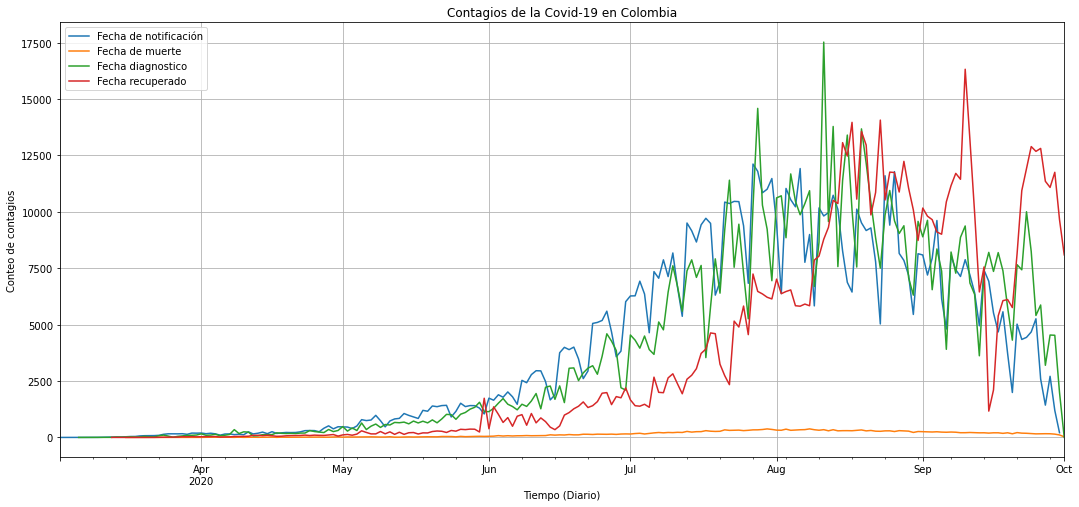

In [6]:
plt.title('Contagios de la Covid-19 en Colombia')
for i in cols:
    df[i].dt.to_period('d').value_counts().sort_index().plot(kind='line', rot=0, figsize=(18, 8), label=i)
# df['Fecha diagnostico'].dt.to_period('d').value_counts().sort_index().plot(kind='line', rot=0, figsize=(25, 8))
plt.grid()
plt.xlabel('Tiempo (Diario)')
plt.ylabel('Conteo de contagios')
plt.legend()
plt.show()

## Mapa de análisis de sentimientos para ciudades y departamentos de Colombia

In [7]:
def load_data_map():
  Colombiageo_url = 'https://drive.google.com/uc?id=1Z5TKmphvMvsnmTU1iBhdRsPHNyurkKq-'
  tweets_map_url = 'https://drive.google.com/uc?id=1LEvApe53QxR4IaGF0lxz10kez6Gd5GwX'
  deptos= gpd.read_file(Colombiageo_url)
  df_1 = pd.read_csv(tweets_map_url)
  return deptos, df_1

def load_data_mun():
    data = pd.read_csv('https://drive.google.com/uc?export=download&id=1GMHzHlsVFmerWWTsosxiGxXIT2LKTBZH')
    return data

In [8]:

deptos, df_1 = load_data_map()
df3=df_1.groupby("DEPARTAMENTO").size()
df3.index.name = 'NOMBRE_DPT'
df3.name='Tweets'

df_3 = pd.merge(deptos, df3, how='left', on=['NOMBRE_DPT'])
df_3=df_3.dropna()
df_3['Tweets']=df_3['Tweets'].astype(int)

min_cn, max_cn = df_3['Tweets'].quantile([0.01,0.99]).apply(round, 2)
colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=min_cn,
    vmax=max_cn
)
colormap.caption="Tweets"

m_Twitt = folium.Map(location=[4.67, -74.1],
                    zoom_start=6,
                    tiles="OpenStreetMap")
style_function = lambda x: {
    'fillColor': colormap(x['properties']['Tweets']),
    'color': 'blue',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    df_3.to_json(),
    name='Tweets',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
    fields=['NOMBRE_DPT', 'Tweets'],
    aliases=['NOMBRE_DPT', 'Tweets'], 
        localize=True
    )
).add_to(m_Twitt)

data=load_data_mun()   

for i in range(0,len(data)):
    folium.Circle(
    location=[data.iloc[i]['Latitud'], data.iloc[i]['Longitud']],
    popup=data.iloc[i]['place_full_name'],
    radius=int(data.iloc[i]['pos_tweets']*100),#*10,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(m_Twitt)

for i in range(0,len(data)):
    folium.Circle(
    location=[data.iloc[i]['Latitud'], data.iloc[i]['Longitud']],
    popup=data.iloc[i]['place_full_name'],
    radius=int(data.iloc[i]['neg_tweets']*100),#*10,
    color='red',
    fill=True,
    fill_color='red'
    ).add_to(m_Twitt) 
#marker = folium.CircleMarker(location=[4.8, -74.3])
#marker.add_to(m_crime)

colormap.add_to(m_Twitt)
folium_static(m_Twitt)
m_Twitt